In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Base Notebook to re-create figures of _

This notebook is the base notebook for 10X's Xenium brain showcase tissue sample. It runs the standard ovrlpy pipeline and saves the results to be used in further analysis.

In [3]:
from pathlib import Path

data_folder_path = Path("/dh-projects/ag-ishaque/raw_data/tiesmeys-ovrlpy/Xenium-brain-2024/replicate1")


### Data loader:

In [4]:
import pandas as  pd

coordinate_df = pd.read_parquet(data_folder_path/"transcripts.parquet")
coordinate_df["feature_name"]=coordinate_df.feature_name.str.decode("utf-8")

# remove dummy molecules:
dummy_mask = (coordinate_df.feature_name.str.contains('BLANK') | coordinate_df.feature_name.str.contains('NegControl'))
coordinate_df = coordinate_df[~dummy_mask]

# format columns:
coordinate_df = coordinate_df[['x_location','y_location','z_location','feature_name','cell_id','overlaps_nucleus','qv']]
coordinate_df.columns = ['x','y','z','gene','cell_id','overlaps_nucleus','qv']
coordinate_df['gene'] = coordinate_df['gene'].astype("category")

print(f"Number of cells: {coordinate_df.cell_id.nunique()}",f"Number of genes: {coordinate_df.gene.nunique()}",f"Number of molecules: {coordinate_df.shape[0]}",sep="\n")

Number of cells: 162034
Number of genes: 248
Number of molecules: 62384369


### Run the basic ovrlppy pipeline:

We expect a roughly estimated 30 cell types in the sample. For the remaining parameters, we use the default values.

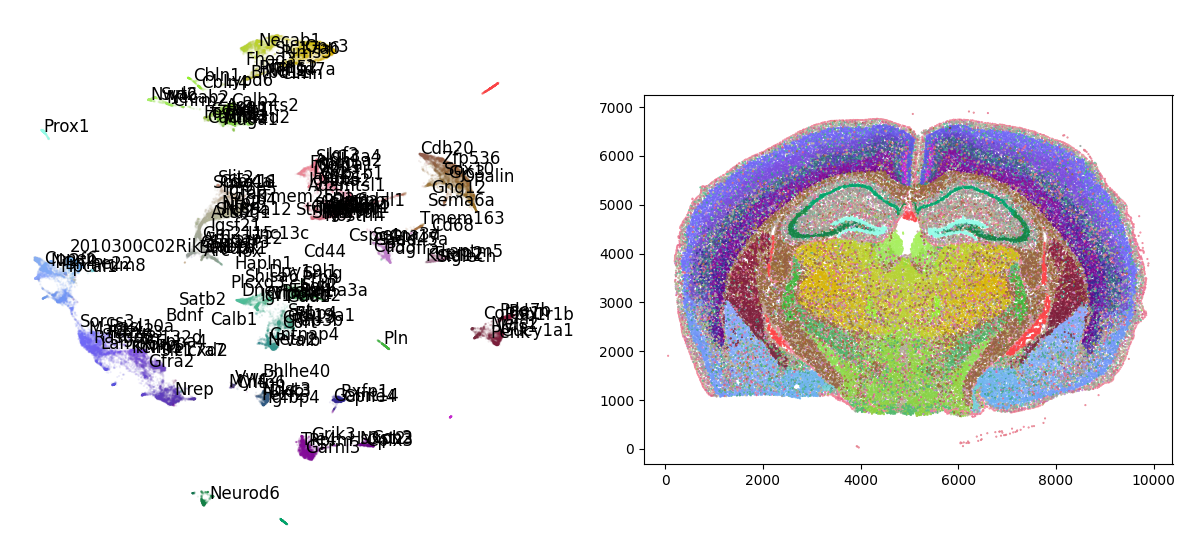

In [46]:
import ovrlpy

visualizer = ovrlpy.load_visualizer('./publication/xenium-brain/xenium-brain.vis')

signal_integrity,signal_strength = visualizer.integrity_map,visualizer.signal_map

visualizer.plot_fit()

### UMAP annotation using external gene expression signatures:

We can use external gene expression signatures to annotate the UMAP. In this case, we use cell features extracted from the allen brain atlas (REF):

/tmp/ipykernel_791571/3009090101.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  signatures = signatures.fillna(0.0)


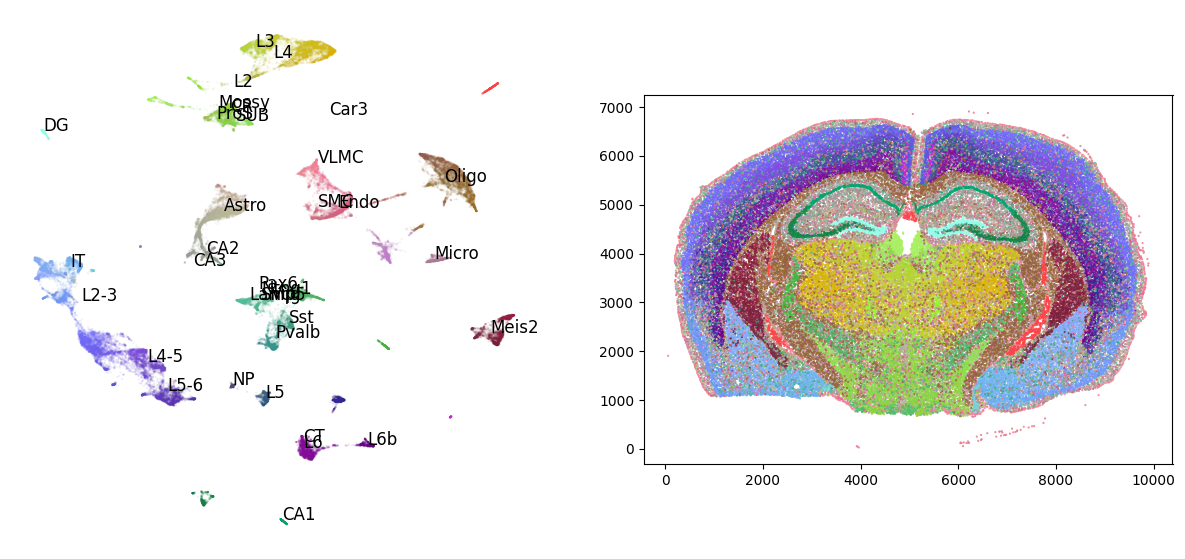

In [47]:
import numpy as np
import matplotlib.pyplot as plt

signatures_ = pd.read_csv('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/trimmed_means.csv',index_col=0)

signatures_ = signatures_.T.groupby(lambda x: x.split('_')[1].split(' ')[0].split('-')[0]).apply(lambda x: x.mean(0)).T

signatures = pd.DataFrame(index=visualizer.genes,columns=signatures_.columns)
signatures = signatures.fillna(0.0)

for gene in visualizer.genes:
    if gene in signatures_.index:
        signatures.loc[gene] = signatures_.loc[gene]

del signatures_ 

signatures.columns=signatures.columns.str.replace('/','-')

visualizer.fit_signatures(signatures)

visualizer.plot_fit()

plt.savefig("./publication/xenium-brain/figures/receptor-fit.svg",dpi=600)

/tmp/ipykernel_791571/1419652633.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_bottom_centroids = fold_df_bottom[fold_df_bottom.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)
/tmp/ipykernel_791571/1419652633.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fold_top_centroids = fold_df_top[fold_df_top.overlaps_nucleus==1].groupby("cell_id").apply(lamb

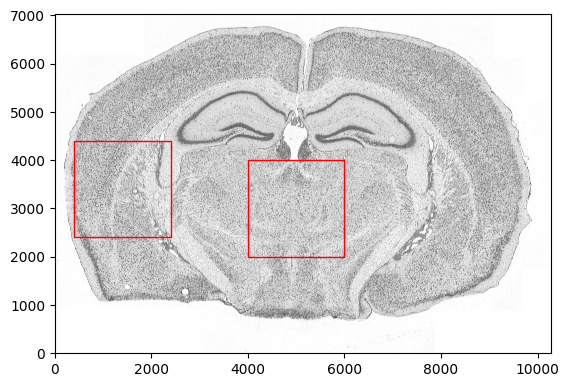

In [7]:
import matplotlib.pyplot as plt

# crop out a central part of the tissue to create artificial overlaps:
xb_,_xb,yb_,_yb = 4000, 6000, 2000, 4000
xt_,_xt,yt_,_yt = 400, 2400, 2400, 4400
fold_bottom_mask = coordinate_df.x.between(xb_,_xb)&coordinate_df.y.between(yb_,_yb)
fold_top_mask = coordinate_df.x.between(xt_,_xt)&coordinate_df.y.between(yt_,_yt)

fold_df_bottom = coordinate_df[fold_bottom_mask].copy()
fold_df_bottom['fold'] = 'bottom'
fold_df_top = coordinate_df[fold_top_mask].copy()
fold_df_top['fold'] = 'top'

ax = plt.gca()
plt.imshow(signal_strength**0.5, cmap='Greys')
rect_b = plt.Rectangle((xb_,yb_),_xb-xb_,_yb-yb_,edgecolor='r',facecolor='none')
ax.add_artist(rect_b)
rect_t = plt.Rectangle((xt_,yt_),_xt-xt_,_yt-yt_,edgecolor='r',facecolor='none')
ax.add_artist(rect_t)
ax.invert_yaxis()
plt.savefig("./publication/xenium-brain/artificial-overlaps/figures/overlap_cutouts.svg",dpi=300)


# move the signal to origin
fold_df_bottom.x-=xb_
fold_df_top.x-=xt_

fold_df_bottom.y-=yb_
fold_df_top.y-=yt_

fold_df_folded = fold_df_bottom.copy()
fold_df_folded.z-=fold_df_bottom.z.max()-fold_df_top.z.min()
fold_df_folded = pd.concat([fold_df_folded,fold_df_top])

fold_bottom_centroids = fold_df_bottom[fold_df_bottom.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)
fold_top_centroids = fold_df_top[fold_df_top.overlaps_nucleus==1].groupby("cell_id").apply(lambda x: x[['x','y']].mean()).astype(int)



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [01:14<00:00,  4.63s/it]


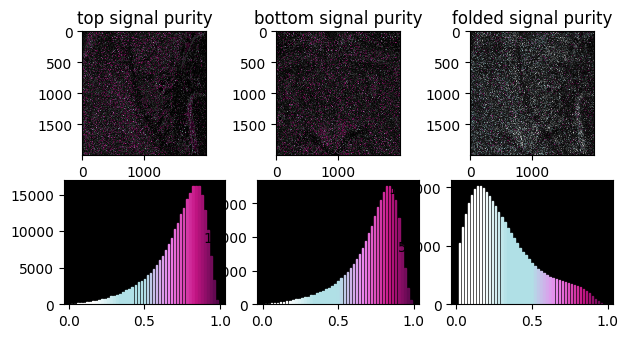

In [144]:
from ovrlpy._utils import _compute_divergence_patched  
from ovrlpy._ovrlp import _BIH_CMAP as cmap
import numpy as np

centimeter = 1/2.54

ovrlpy.pre_process_coordinates(fold_df_bottom)
ovrlpy.pre_process_coordinates(fold_df_top)
ovrlpy.pre_process_coordinates(fold_df_folded)

min_expression = 1.5

coherence_bottom, signal_bottom = _compute_divergence_patched(fold_df_bottom, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_top, signal_top = _compute_divergence_patched(fold_df_top, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

coherence_folded, signal_folded = _compute_divergence_patched(fold_df_folded, visualizer.genes, visualizer.pca_2d.components_,
    KDE_bandwidth=1, min_expression=min_expression, patch_length=500)

def plot_purity_distribution(coherence,density=None,ax=None):
    if ax is None:
        ax = plt.gca()
    vals,bins = np.histogram(coherence, bins=50, range=(0,1), density=density)
    colors = cmap(bins[1:-1])
    bars = ax.bar(bins[1:-1],vals[1:],width=0.01)
    for i,bar in enumerate(bars):
        bar.set_color(colors[i])


fig = plt.figure(figsize=(18*centimeter,9*centimeter))

ax = plt.subplot(231,facecolor='k')
plt.title('top signal purity')
plt.imshow(coherence_top.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_top.T/signal_top.max(), interpolation='nearest')
ax = plt.subplot(234,facecolor='k')
plot_purity_distribution(coherence_top[signal_bottom>1.5],ax=ax)

ax = plt.subplot(232,facecolor='k')
plt.title('bottom signal purity')
plt.imshow(coherence_bottom.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_bottom.T/signal_bottom.max(), interpolation='nearest')
ax = plt.subplot(235,facecolor='k')
plot_purity_distribution(coherence_bottom[signal_top>1.5],ax=ax)

ax = plt.subplot(233,facecolor='k')
plt.title('folded signal purity')
plt.imshow(coherence_folded.T**1, cmap=cmap, vmin= 0.0, vmax=1.0, alpha = signal_folded.T/signal_folded.max(), interpolation='nearest')
ax = plt.subplot(236,facecolor='k')
plot_purity_distribution(coherence_folded[signal_folded>1.5],ax=ax)

plt.savefig("./publication/xenium-brain/artificial-overlaps/figures/purity_summary.svg",dpi=600)

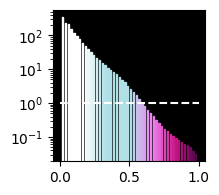

In [9]:
hist_top, bins,  = np.histogram(coherence_top[signal_top>2.5],bins=np.linspace(0,1,50),density=True)
hist_bot, bins,  = np.histogram(coherence_bottom[signal_bottom>2.5],bins=np.linspace(0,1,50),density=True)
hist_folded, bins,  = np.histogram(coherence_folded[signal_folded>2.5],bins=np.linspace(0,1,50),density=True)
hist_quotient = hist_folded/((hist_top+hist_bot)/2)

plt.figure(figsize=(5*centimeter,5*centimeter))

ax = plt.subplot(111,facecolor='k')
colors = cmap(bins[1:-1])
bars = ax.bar(bins[1:-1],hist_quotient[1:],width=0.01)
for i,bar in enumerate(bars):
    bar.set_color(colors[i])
    
ax.set_yscale('log')
plt.hlines(1,0,1,linestyles='dashed',color='w')
# plt.vlines(0.48,0,500,linestyles='dashed',color='w')

plt.savefig("./publication/xenium-brain/artificial-overlaps/figures/purity_quotient.svg",dpi=300)

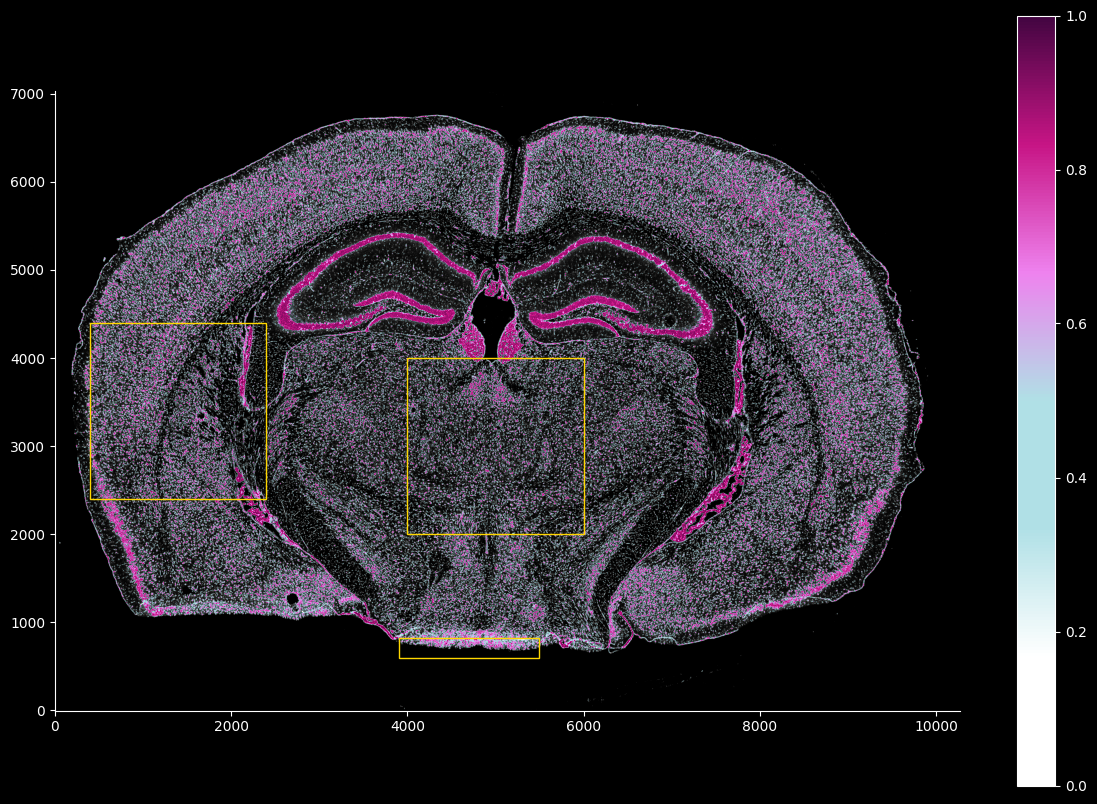

In [169]:
fold_edges_1 = [[3900,5500],[600,820]]

signal_integrity_ = signal_integrity.copy()
signal_integrity_[signal_strength<1.5] = np.nan

Fig, ax = ovrlpy.plot_signal_integrity(signal_integrity,signal_strength,plot_hist=False)

# rect = plt.Rectangle((fold_edges[0][0],fold_edges[1][0]),fold_edges[0][1]-fold_edges[0][0],fold_edges[1][1]-fold_edges[1][0],edgecolor='lime',facecolor='none')
# ax[0].add_artist(rect)

rect_1 = plt.Rectangle((fold_edges_1[0][0],fold_edges_1[1][0]),fold_edges_1[0][1]-fold_edges_1[0][0],fold_edges_1[1][1]-fold_edges_1[1][0],edgecolor='gold',facecolor='none')
ax[0].add_artist(rect_1)

rect_top = plt.Rectangle((xt_,yt_),_xt-xt_,_yt-yt_,edgecolor='gold',facecolor='none')
ax[0].add_artist(rect_top)

rect_bottom = plt.Rectangle((xb_,yb_),_xb-xb_,_yb-yb_,edgecolor='gold',facecolor='none')
ax[0].add_artist(rect_bottom)

plt.savefig("./publication/xenium-brain/artificial-overlaps/figures/signal_integrity_rectangles.svg",dpi=300)


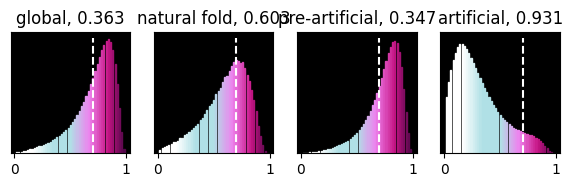

In [165]:
fold_edges_1 = [[3900,5500],[600,820]]
# fold_edges_1 = [[1000,2500],[1000,1200]]

natural_fold_over_cutout_2 = signal_integrity_[fold_edges_1[1][0]:fold_edges_1[1][1],fold_edges_1[0][0]:fold_edges_1[0][1]]

# plt.hist(natural_fold_over_cutout_2[~np.isnan(natural_fold_over_cutout_2)],bins=50,density=True,alpha=0.5)

# ovrlpy.plot_signal_integrity(natural_fold_over_cutout_1,signal_strength[fold_edges[1][0]:fold_edges[1][1],fold_edges[0][0]:fold_edges[0][1]],plot_hist=True)
# ovrlpy.plot_signal_integrity(natural_fold_over_cutout_2,signal_strength[fold_edges_1[1][0]:fold_edges_1[1][1],fold_edges_1[0][0]:fold_edges_1[0][1]],plot_hist=True)



plt.figure(figsize=(18*centimeter,4*centimeter))

ax = plt.subplot(141, facecolor='k',title=f'global, {str((signal_integrity[signal_strength>1.5]<0.7).mean())[:5]}')
plot_purity_distribution(signal_integrity_,density=True)
plt.yticks([])
plt.vlines(0.7,0,3,linestyles='dashed',color='w')

plt.subplot(142, facecolor='k',title=f'natural fold, {str((natural_fold_over_cutout_2[~np.isnan(natural_fold_over_cutout_2)]<0.7).mean())[:5]}')
plot_purity_distribution(natural_fold_over_cutout_2,density=True)
plt.yticks([])
plt.vlines(0.7,0,2.8,linestyles='dashed',color='w')


coherence_pre = np.concatenate([coherence_top[signal_top>1.5],coherence_bottom[signal_bottom>1.5]])
plt.subplot(143, facecolor='k',title=f'pre-artificial, {str((coherence_pre<0.7).mean())[:5]}')
plot_purity_distribution(coherence_pre,density=True)
plt.yticks([])
plt.vlines(0.7,0,3.2,linestyles='dashed',color='w')

plt.subplot(144, facecolor='k',title=f'artificial, {str((coherence_folded[signal_folded>1.5]<0.7).mean())[:5]}')
plot_purity_distribution(coherence_folded[signal_folded>1.5],density=True)
plt.yticks([])
plt.vlines(0.7,0,2.2,linestyles='dashed',color='w')

# plt.tight_layout()

plt.savefig("./publication/xenium-brain/artificial-overlaps/figures/natural_vs_artificial_folds.svg",dpi=600)

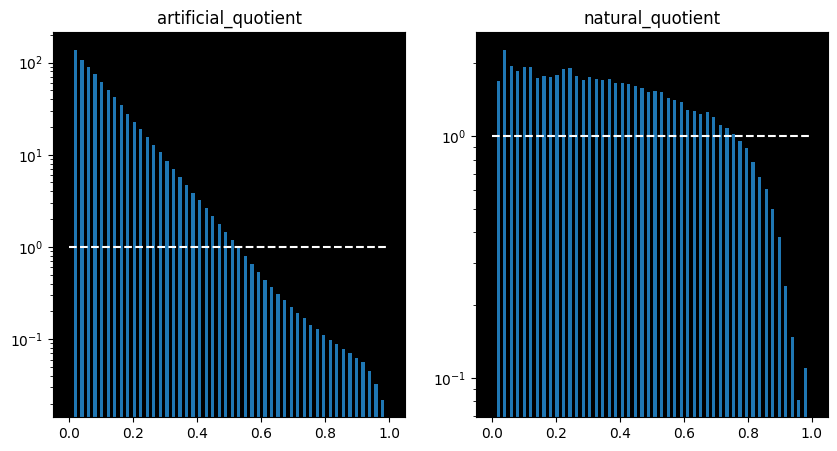

In [133]:
hist_top, bins,  = np.histogram(coherence_top[signal_top>1.5],bins=np.linspace(0,1,50),density=True)
hist_bot, bins,  = np.histogram(coherence_bottom[signal_bottom>1.5],bins=np.linspace(0,1,50),density=True)
hist_folded, bins,  = np.histogram(coherence_folded[signal_folded>1.5],bins=np.linspace(0,1,50),density=True)
hist_quotient = hist_folded/((hist_top+hist_bot)/2)

hist_global, bins,  = np.histogram(signal_integrity_[signal_strength>1.5],bins=np.linspace(0,1,50),density=True)
hist_natural_fold, bins,  = np.histogram(natural_fold_over_cutout_2[~np.isnan(natural_fold_over_cutout_2)],bins=np.linspace(0,1,50),density=True)
hist_quotient_natural_fold = hist_natural_fold/hist_global

plt.figure(figsize=(10,5))
plt.subplot(121, facecolor='k',title='artificial_quotient')
plt.bar(bins[1:-1],hist_quotient[1:],width=0.01)
plt.yscale('log')

plt.hlines(1,0,1,linestyles='dashed',color='w')

plt.subplot(122, facecolor='k',title='natural_quotient') 
plt.bar(bins[1:-1],hist_quotient_natural_fold[1:],width=0.01)
plt.yscale('log')
plt.hlines(1,0,1,linestyles='dashed',color='w')

